In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import textwrap
from textwrap import wrap
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [30]:
Performance = pd.read_csv('Performance.csv')

In [31]:
Performance.dtypes

Dates     object
SMB      float64
HML      float64
RMW      float64
CMA      float64
WML      float64
Rm-Rf    float64
dtype: object

In [32]:
Performance.head(5)

,Dates,SMB,HML,RMW,CMA,WML,Rm-Rf
0,30/06/2018,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,31/07/2018,99.537103,101.239198,100.308521,100.406199,100.287856,100.386521
2,31/08/2018,101.699901,98.651363,100.103449,99.559428,100.952116,99.800696
3,28/09/2018,103.727160,96.759501,102.098035,98.698678,101.007008,98.859131
4,31/10/2018,101.778104,96.451877,102.761596,96.312747,100.742688,100.808020


In [33]:
Performance['Dates'] = pd.to_datetime(Performance['Dates'], dayfirst=True)

In [35]:
import matplotlib.dates as mdates

In [ ]:
Performance.set_index('Dates', inplace=True)


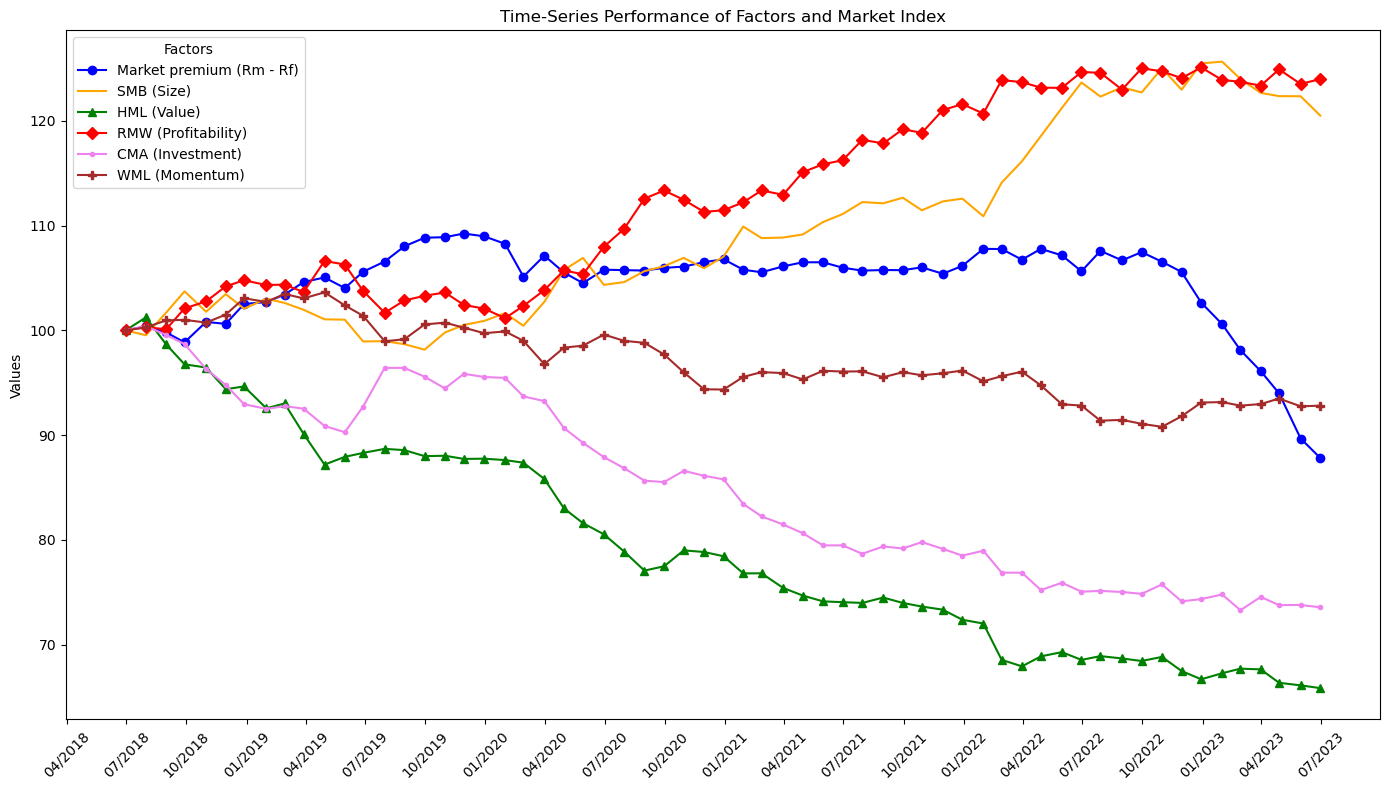

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import textwrap
from textwrap import wrap
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Load and preprocess data
monthly_returns = pd.read_csv('Monthly_return.csv')
performance = pd.read_csv('Performance.csv')

monthly_returns['Dates'] = pd.to_datetime(monthly_returns['Dates'], dayfirst=True)
performance['Dates'] = pd.to_datetime(performance['Dates'], dayfirst=True)
plt.figure(figsize = (14,8))
factor_colors = {
    'Rm-Rf': 'blue',
    'SMB': 'orange',
    'HML': 'green',
    'RMW': 'red',
    'CMA': 'violet',
    'WML': 'brown'}
factor_labels = {
    'Rm-Rf': 'Market premium (Rm - Rf)',
    'SMB': 'SMB (Size)',
    'HML': 'HML (Value)',
    'RMW': 'RMW (Profitability)',
    'CMA': 'CMA (Investment)',
    'WML': 'WML (Momentum)',
}
factor_markers = {
    'Rm-Rf': 'o', # Circle
    'SMB': '', # None
    'HML': '^', # Triangle
    'RMW': 'D', # Diamond
    'CMA': '.', # Point
    'WML': 'P', # Pentagon
}
for factor, color in factor_colors.items():
    plt.plot(Performance.index, Performance[factor], 
             label=factor_labels[factor], color=color, 
             marker=factor_markers[factor], markersize=6)
# Set the x-axis to display dates in "mm/yyyy" format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.legend(title="Factors")
plt.title("Time-Series Performance of Factors and Market Index")
plt.xlabel("")
plt.ylabel("Values")
plt.xticks(rotation=45)

# Ensure starting point stems from the y-axis
plt.tight_layout()

# Turn off grid lines
plt.grid(False)

plt.show()

In [43]:
Monthly_return = pd.read_csv('Monthly_return.csv')

In [44]:
Monthly_return.dtypes

Dates       object
Rf         float64
CDAX       float64
SMB        float64
HML        float64
RMW        float64
CMA        float64
WML        float64
Rm - Rf    float64
dtype: object

In [45]:
Monthly_return['Dates'] = pd.to_datetime(Monthly_return['Dates'], dayfirst=True)

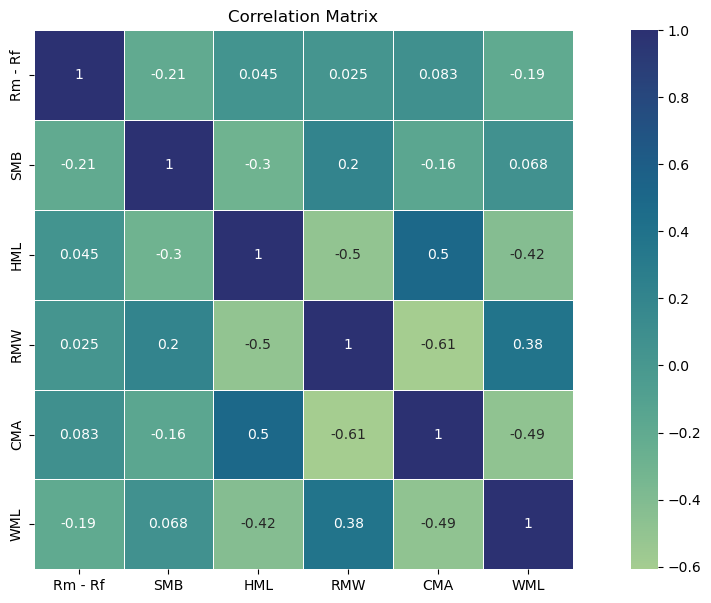

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import textwrap
from textwrap import wrap
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Load and preprocess data
monthly_returns = pd.read_csv('Monthly_return.csv')
performance = pd.read_csv('Performance.csv')

monthly_returns['Dates'] = pd.to_datetime(monthly_returns['Dates'], dayfirst=True)
performance['Dates'] = pd.to_datetime(performance['Dates'], dayfirst=True)

plt.rcParams['figure.figsize'] = [15,7]
ax = sns.heatmap(monthly_returns[['Rm - Rf', 'SMB', 'HML' ,'RMW', 'CMA', 'WML']].corr(), annot = True, linewidths=0.5,square=True,cmap='crest',cbar=True)
ax.set_title('Correlation Matrix')
plt.show()

In [73]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import f

def run_grs_test(portfolios, factors, rf):
    # Prepare the excess returns for the portfolios
    excess_returns = portfolios.subtract(rf, axis=0)

    # Collect alphas, residuals, and adjusted R-squared
    alphas = []
    residuals = []
    adj_r_squared = []

    for column in excess_returns:
        X = sm.add_constant(factors)
        y = excess_returns[column]
        model = sm.OLS(y, X).fit()
        alphas.append(model.params['const'])
        residuals.append(model.resid)
        adj_r_squared.append(model.rsquared_adj)
    
    # Convert residuals and alphas into appropriate formats for GRS test
    residuals_matrix = pd.DataFrame(residuals).T
    alpha_vector = pd.Series(alphas)

    # Calculate covariance of residuals and factors
    residuals_cov = residuals_matrix.cov()
    factors_cov = factors.cov()

    # Number of assets (portfolios), number of time periods, and number of factors
    N = len(portfolios.columns)
    T = factors.shape[0]
    K = factors.shape[1]

    # Calculate the GRS statistic and corresponding p-value
    GRS_statistic = ((T - N - K) / N) * (alpha_vector.T @ np.linalg.inv(residuals_cov) @ alpha_vector) / (1 + factors.mean().T @ np.linalg.inv(factors_cov) @ factors.mean())
    GRS_p_value = 1 - f.cdf(GRS_statistic, N, T-N-K)

    # Calculate mean absolute intercepts (alphas)
    mean_absolute_alpha = np.mean(np.abs(alphas))

    # Calculate mean adjusted R-squared
    mean_adj_r_squared = np.mean(adj_r_squared)


    return {
        'GRS Statistic': GRS_statistic,
        'GRS p-value': GRS_p_value,
        'Mean Absolute Alpha': mean_absolute_alpha,
        'Mean Adjusted R-squared': mean_adj_r_squared
    }

# Example usage:
# Load your data first
monthly_returns = pd.read_csv('Monthly_return.csv')
performance = pd.read_csv('Performance.csv')

monthly_returns['Dates'] = pd.to_datetime(monthly_returns['Dates'], dayfirst=True)
performance['Dates'] = pd.to_datetime(performance['Dates'], dayfirst=True)

three_factors = monthly_returns[['Rm - Rf', 'SMB', 'HML']]
rf = monthly_returns['Rf']

# Define your portfolio groups
size_bm_portfolios = performance[['BH_BM', 'BN_BM', 'BL_BM', 'SH_BM', 'SN_BM', 'SL_BM']]
size_profit_portfolios = performance[['BR_PROF', 'BN_PROF', 'BW_PROF', 'SR_PROF', 'SN_PROF', 'SW_PROF']]
size_investment_portfolios = performance[['BC_INV', 'BN_INV', 'BA_INV', 'SC_INV', 'SN_INV', 'SA_INV']]
size_momentum_portfolios = performance[['BW_MOME', 'BN_MOME', 'BL_MOME', 'SW_MOME', 'SN_MOME', 'SL_MOME']]

# Add other portfolio groups similarly

# Run GRS Test
results_size_bm_3_factor = run_grs_test(size_bm_portfolios, three_factors, rf)
results_size_profit_3_factor = run_grs_test(size_profit_portfolios, three_factors, rf)
results_size_invement_3_factor = run_grs_test(size_investment_portfolios, three_factors, rf)
results_size_momentum_3_factor = run_grs_test(size_momentum_portfolios, three_factors, rf)

# Run for other groups similarly
print("GRS test on Fama-French 3-factor:")
print("Size/BM Results:", results_size_bm_3_factor)
print("Size/Profitability Results:", results_size_profit_3_factor)
print("Size/Invement Results:", results_size_invement_3_factor)
print("Size/Momentum Results:", results_size_momentum_3_factor)

# Print other results similarly


GRS test on Fama-French 3-factor:
Size/BM Results: {'GRS Statistic': 2.396227301166044, 'GRS p-value': 0.040774355890398795, 'Mean Absolute Alpha': 0.0017397097506215283, 'Mean Adjusted R-squared': 0.6722465190438834}
Size/Profitability Results: {'GRS Statistic': 2.017675309401098, 'GRS p-value': 0.0802228467333348, 'Mean Absolute Alpha': 0.002181025209366959, 'Mean Adjusted R-squared': 0.599415234609402}
Size/Invement Results: {'GRS Statistic': 3.1709426662185867, 'GRS p-value': 0.010133891279536789, 'Mean Absolute Alpha': 0.002153893671837171, 'Mean Adjusted R-squared': 0.5976483239952447}
Size/Momentum Results: {'GRS Statistic': 2.8837879820772514, 'GRS p-value': 0.016958692468037606, 'Mean Absolute Alpha': 0.0021030732668773765, 'Mean Adjusted R-squared': 0.6195107784144221}


In [74]:
monthly_returns = pd.read_csv('Monthly_return.csv')
performance = pd.read_csv('Performance.csv')

monthly_returns['Dates'] = pd.to_datetime(monthly_returns['Dates'], dayfirst=True)
performance['Dates'] = pd.to_datetime(performance['Dates'], dayfirst=True)

size_bm_portfolios = performance[['BH_BM', 'BN_BM', 'BL_BM', 'SH_BM', 'SN_BM', 'SL_BM']]
size_profit_portfolios = performance[['BR_PROF', 'BN_PROF', 'BW_PROF', 'SR_PROF', 'SN_PROF', 'SW_PROF']]
size_investment_portfolios = performance[['BC_INV', 'BN_INV', 'BA_INV', 'SC_INV', 'SN_INV', 'SA_INV']]
size_momentum_portfolios = performance[['BW_MOME', 'BN_MOME', 'BL_MOME', 'SW_MOME', 'SN_MOME', 'SL_MOME']]


def run_grs_test_five_factor(portfolios, factors, rf):
    # Prepare the excess returns for the portfolios
    excess_returns = portfolios.subtract(rf, axis=0)

    # Collect alphas, residuals, and adjusted R-squared
    alphas = []
    residuals = []
    adj_r_squared = []

    for column in excess_returns:
        X = sm.add_constant(factors)
        y = excess_returns[column]
        model = sm.OLS(y, X).fit()
        alphas.append(model.params['const'])
        residuals.append(model.resid)
        adj_r_squared.append(model.rsquared_adj)
    
    # Convert residuals and alphas into appropriate formats for GRS test
    residuals_matrix = pd.DataFrame(residuals).T
    alpha_vector = pd.Series(alphas)

    # Calculate covariance of residuals and factors
    residuals_cov = residuals_matrix.cov()
    factors_cov = factors.cov()

    # Number of assets (portfolios), number of time periods, and number of factors
    N = len(portfolios.columns)
    T = factors.shape[0]
    K = factors.shape[1]

    # Calculate the GRS statistic and corresponding p-value
    GRS_statistic = ((T - N - K) / N) * (alpha_vector.T @ np.linalg.inv(residuals_cov) @ alpha_vector) / (1 + factors.mean().T @ np.linalg.inv(factors_cov) @ factors.mean())
    GRS_p_value = 1 - f.cdf(GRS_statistic, N, T-N-K)

    # Calculate mean absolute intercepts (alphas)
    mean_absolute_alpha = np.mean(np.abs(alphas))

    # Calculate mean adjusted R-squared
    mean_adj_r_squared = np.mean(adj_r_squared)

    return {
        'GRS Statistic': GRS_statistic,
        'GRS p-value': GRS_p_value,
        'Mean Absolute Alpha': mean_absolute_alpha,
        'Mean Adjusted R-squared': mean_adj_r_squared
    }

# Example usage after loading your data:
five_factors = monthly_returns[['Rm - Rf', 'SMB', 'HML', 'RMW', 'CMA']]  # Adding RMW and CMA factors
rf = monthly_returns['Rf']

# Define your portfolio groups and run GRS Test
results_size_bm_5_factor = run_grs_test_five_factor(size_bm_portfolios, five_factors, rf)
results_size_profit_5_factor = run_grs_test_five_factor(size_profit_portfolios, five_factors, rf)
results_size_invement_5_factor = run_grs_test_five_factor(size_investment_portfolios, five_factors, rf)
results_size_momentum_5_factor = run_grs_test_five_factor(size_momentum_portfolios, five_factors, rf)



print("GRS test on Fama-French 5-factor:")
print("Size/BM Results:", results_size_bm_5_factor)
print("Size/Profitability Results:", results_size_profit_5_factor)
print("Size/Invement Results:", results_size_invement_5_factor)
print("Size/Momentum Results:", results_size_momentum_5_factor)

GRS test on Fama-French 5-factor:
Size/BM Results: {'GRS Statistic': 2.455550623821849, 'GRS p-value': 0.03726013346072832, 'Mean Absolute Alpha': 0.0017502651830547528, 'Mean Adjusted R-squared': 0.6954812238852087}
Size/Profitability Results: {'GRS Statistic': 2.002063635020129, 'GRS p-value': 0.08331088881635629, 'Mean Absolute Alpha': 0.002283902995307601, 'Mean Adjusted R-squared': 0.6781639355088442}
Size/Invement Results: {'GRS Statistic': 3.874676609607924, 'GRS p-value': 0.003046166332152045, 'Mean Absolute Alpha': 0.0021911704961666235, 'Mean Adjusted R-squared': 0.704414131171826}
Size/Momentum Results: {'GRS Statistic': 3.8463415084229537, 'GRS p-value': 0.0031989862935533075, 'Mean Absolute Alpha': 0.002211774935530648, 'Mean Adjusted R-squared': 0.6609707097523388}


In [75]:
monthly_returns = pd.read_csv('Monthly_return.csv')
performance = pd.read_csv('Performance.csv')

monthly_returns['Dates'] = pd.to_datetime(monthly_returns['Dates'], dayfirst=True)
performance['Dates'] = pd.to_datetime(performance['Dates'], dayfirst=True)

size_bm_portfolios = performance[['BH_BM', 'BN_BM', 'BL_BM', 'SH_BM', 'SN_BM', 'SL_BM']]
size_profit_portfolios = performance[['BR_PROF', 'BN_PROF', 'BW_PROF', 'SR_PROF', 'SN_PROF', 'SW_PROF']]
size_investment_portfolios = performance[['BC_INV', 'BN_INV', 'BA_INV', 'SC_INV', 'SN_INV', 'SA_INV']]
size_momentum_portfolios = performance[['BW_MOME', 'BN_MOME', 'BL_MOME', 'SW_MOME', 'SN_MOME', 'SL_MOME']]


def run_grs_test_six_factor(portfolios, factors, rf):
    # Prepare the excess returns for the portfolios
    excess_returns = portfolios.subtract(rf, axis=0)

    # Collect alphas, residuals, and adjusted R-squared
    alphas = []
    residuals = []
    adj_r_squared = []

    for column in excess_returns:
        X = sm.add_constant(factors)
        y = excess_returns[column]
        model = sm.OLS(y, X).fit()
        alphas.append(model.params['const'])
        residuals.append(model.resid)
        adj_r_squared.append(model.rsquared_adj)
    
    # Convert residuals and alphas into appropriate formats for GRS test
    residuals_matrix = pd.DataFrame(residuals).T
    alpha_vector = pd.Series(alphas)

    # Calculate covariance of residuals and factors
    residuals_cov = residuals_matrix.cov()
    factors_cov = factors.cov()

    # Number of assets (portfolios), number of time periods, and number of factors
    N = len(portfolios.columns)
    T = factors.shape[0]
    K = factors.shape[1]

    # Calculate the GRS statistic and corresponding p-value
    GRS_statistic = ((T - N - K) / N) * (alpha_vector.T @ np.linalg.inv(residuals_cov) @ alpha_vector) / (1 + factors.mean().T @ np.linalg.inv(factors_cov) @ factors.mean())
    GRS_p_value = 1 - f.cdf(GRS_statistic, N, T-N-K)

    # Calculate mean absolute intercepts (alphas)
    mean_absolute_alpha = np.mean(np.abs(alphas))

    # Calculate mean adjusted R-squared
    mean_adj_r_squared = np.mean(adj_r_squared)

    return {
        'GRS Statistic': GRS_statistic,
        'GRS p-value': GRS_p_value,
        'Mean Absolute Alpha': mean_absolute_alpha,
        'Mean Adjusted R-squared': mean_adj_r_squared
    }

# Example usage after loading your data:
# Make sure your factors DataFrame includes all six factors
six_factors = monthly_returns[['Rm - Rf', 'SMB', 'HML', 'RMW', 'CMA', 'WML']]
rf = monthly_returns['Rf']

# Define your portfolio groups and run GRS Test
results_size_bm_6_factor = run_grs_test_six_factor(size_bm_portfolios, six_factors, rf)
results_size_profit_6_factor = run_grs_test_six_factor(size_profit_portfolios, six_factors, rf)
results_size_invement_6_factor = run_grs_test_six_factor(size_investment_portfolios, six_factors, rf)
results_size_momentum_6_factor = run_grs_test_six_factor(size_momentum_portfolios, six_factors, rf)



print("Fama-French 6-factor:")
print("Size/BM Results:", results_size_bm_6_factor)
print("Size/Profitability Results:", results_size_profit_6_factor)
print("Size/Invement Results:", results_size_invement_6_factor)
print("Size/Momentum Results:", results_size_momentum_6_factor)

Fama-French 6-factor:
Size/BM Results: {'GRS Statistic': 1.493159853615835, 'GRS p-value': 0.20069900563557552, 'Mean Absolute Alpha': 0.0025020439870685517, 'Mean Adjusted R-squared': 0.708471862918043}
Size/Profitability Results: {'GRS Statistic': 1.5116654410559092, 'GRS p-value': 0.1945947712329097, 'Mean Absolute Alpha': 0.002757197965377853, 'Mean Adjusted R-squared': 0.693958340857125}
Size/Invement Results: {'GRS Statistic': 2.6433051675285966, 'GRS p-value': 0.026931237793563767, 'Mean Absolute Alpha': 0.002758510824942297, 'Mean Adjusted R-squared': 0.7136989394603707}
Size/Momentum Results: {'GRS Statistic': 1.8949856463845953, 'GRS p-value': 0.10098994150639984, 'Mean Absolute Alpha': 0.0026798484699576317, 'Mean Adjusted R-squared': 0.7066384251637347}


In [76]:
monthly_returns = pd.read_csv('Monthly_return.csv')
performance = pd.read_csv('Performance.csv')

monthly_returns['Dates'] = pd.to_datetime(monthly_returns['Dates'], dayfirst=True)
performance['Dates'] = pd.to_datetime(performance['Dates'], dayfirst=True)

size_bm_portfolios = performance[['BH_BM', 'BN_BM', 'BL_BM', 'SH_BM', 'SN_BM', 'SL_BM']]
size_profit_portfolios = performance[['BR_PROF', 'BN_PROF', 'BW_PROF', 'SR_PROF', 'SN_PROF', 'SW_PROF']]
size_investment_portfolios = performance[['BC_INV', 'BN_INV', 'BA_INV', 'SC_INV', 'SN_INV', 'SA_INV']]
size_momentum_portfolios = performance[['BW_MOME', 'BN_MOME', 'BL_MOME', 'SW_MOME', 'SN_MOME', 'SL_MOME']]


def run_grs_test_carhart_four_factor(portfolios, factors, rf):
    # Prepare the excess returns for the portfolios
    excess_returns = portfolios.subtract(rf, axis=0)

    # Collect alphas, residuals, and adjusted R-squared
    alphas = []
    residuals = []
    adj_r_squared = []

    for column in excess_returns:
        X = sm.add_constant(factors)
        y = excess_returns[column]
        model = sm.OLS(y, X).fit()
        alphas.append(model.params['const'])
        residuals.append(model.resid)
        adj_r_squared.append(model.rsquared_adj)
    
    # Convert residuals and alphas into appropriate formats for GRS test
    residuals_matrix = pd.DataFrame(residuals).T
    alpha_vector = pd.Series(alphas)

    # Calculate covariance of residuals and factors
    residuals_cov = residuals_matrix.cov()
    factors_cov = factors.cov()

    # Number of assets (portfolios), number of time periods, and number of factors
    N = len(portfolios.columns)
    T = factors.shape[0]
    K = factors.shape[1]

    # Calculate the GRS statistic and corresponding p-value
    GRS_statistic = ((T - N - K) / N) * (alpha_vector.T @ np.linalg.inv(residuals_cov) @ alpha_vector) / (1 + factors.mean().T @ np.linalg.inv(factors_cov) @ factors.mean())
    GRS_p_value = 1 - f.cdf(GRS_statistic, N, T-N-K)

    # Calculate mean absolute intercepts (alphas)
    mean_absolute_alpha = np.mean(np.abs(alphas))

    # Calculate mean adjusted R-squared
    mean_adj_r_squared = np.mean(adj_r_squared)

    return {
        'GRS Statistic': GRS_statistic,
        'GRS p-value': GRS_p_value,
        'Mean Absolute Alpha': mean_absolute_alpha,
        'Mean Adjusted R-squared': mean_adj_r_squared
    }

# Example usage after loading your data:
# Make sure 'WML' or your specific momentum factor is included in the 'factors' DataFrame
four_factors = monthly_returns[['Rm - Rf', 'SMB', 'HML', 'WML']]
rf = monthly_returns['Rf']

# Define your portfolio groups and run GRS Test
results_size_bm_4_factor = run_grs_test_carhart_four_factor(size_bm_portfolios, four_factors, rf)
results_size_profit_4_factor = run_grs_test_carhart_four_factor(size_profit_portfolios, four_factors, rf)
results_size_invement_4_factor = run_grs_test_carhart_four_factor(size_investment_portfolios, four_factors, rf)
results_size_momentum_4_factor = run_grs_test_carhart_four_factor(size_momentum_portfolios, four_factors, rf)



print("GRS test on Carhart-factor:")
print("Size/BM Results:", results_size_bm_4_factor)
print("Size/Profitability Results:", results_size_profit_4_factor)
print("Size/Invement Results:", results_size_invement_4_factor)
print("Size/Momentum Results:", results_size_momentum_4_factor)

GRS test on Carhart-factor:
Size/BM Results: {'GRS Statistic': 1.5206720012562414, 'GRS p-value': 0.19074069775155555, 'Mean Absolute Alpha': 0.002055603556486143, 'Mean Adjusted R-squared': 0.68110903480834}
Size/Profitability Results: {'GRS Statistic': 1.697412969255425, 'GRS p-value': 0.14112916216096671, 'Mean Absolute Alpha': 0.0023478158369394384, 'Mean Adjusted R-squared': 0.6144258923707447}
Size/Invement Results: {'GRS Statistic': 2.44620483721679, 'GRS p-value': 0.03757204515707768, 'Mean Absolute Alpha': 0.0022758979030177533, 'Mean Adjusted R-squared': 0.6105735832226328}
Size/Momentum Results: {'GRS Statistic': 1.510251684133001, 'GRS p-value': 0.19411328645254033, 'Mean Absolute Alpha': 0.002271602793310293, 'Mean Adjusted R-squared': 0.6688426389616652}


In [78]:
import pandas as pd
import statsmodels.api as sm

# Load and preprocess data
monthly_returns = pd.read_csv('Monthly_return.csv')
performance = pd.read_csv('Performance.csv')

monthly_returns['Dates'] = pd.to_datetime(monthly_returns['Dates'], dayfirst=True)
performance['Dates'] = pd.to_datetime(performance['Dates'], dayfirst=True)

# Prepare the data for regression analysis
# Extract the factors from the monthly returns dataframe
factors = ['Rm - Rf', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
factors_df = monthly_returns[factors]
factors_df = sm.add_constant(factors_df)  # adding a constant for the regression intercept

# Perform factor redundancy tests
results = []
for factor in factors:
    dependent_var = monthly_returns[factor]
    independent_vars = factors_df.drop(factor, axis=1)  # Use all other factors as independent variables
    
    # Fit regression model
    model = sm.OLS(dependent_var, independent_vars).fit()
    
    # Extract and store results
    result = {
        'Factor': factor,
        'Intercept': f"{model.params['const']:.4f} ({model.tvalues['const']:.4f})",
        'Adjusted R-squared': f"{model.rsquared_adj:.4f}"
    }
    
    # Add coefficients and t-statistics for other factors
    for f in independent_vars.columns[1:]:  # skip the constant
        result[f] = f"{model.params[f]:.4f} ({model.tvalues[f]:.4f})"
    
    results.append(result)

# Convert results to DataFrame and set Factor as index for display
results_df = pd.DataFrame(results)
results_df.set_index('Factor', inplace=True)
print(results_df)


                 Intercept Adjusted R-squared                SMB  \
Factor                                                             
Rm - Rf  -0.0026 (-1.2806)             0.0188  -0.2294 (-1.7360)   
SMB      -0.0000 (-0.0215)             0.0676                NaN   
HML      -0.0046 (-2.8602)             0.3241  -0.2028 (-1.8641)   
RMW        0.0004 (0.2472)             0.3837    0.0719 (0.7573)   
CMA      -0.0024 (-1.5163)             0.4224    0.0065 (0.0628)   
WML      -0.0038 (-3.2237)             0.2555  -0.0771 (-0.9292)   

                       HML                RMW                CMA  \
Factor                                                             
Rm - Rf  -0.0774 (-0.4713)    0.1889 (0.9840)    0.0676 (0.3779)   
SMB      -0.2981 (-1.8641)    0.1462 (0.7573)    0.0113 (0.0628)   
HML                    NaN  -0.2692 (-1.7275)    0.2188 (1.5084)   
RMW      -0.1945 (-1.7275)                NaN  -0.4071 (-3.6026)   
CMA        0.1848 (1.5084)  -0.4760 (-3.6026)  

In [79]:
import pandas as pd
import statsmodels.api as sm

# Load and preprocess data
monthly_returns = pd.read_csv('Monthly_return.csv')
performance = pd.read_csv('Performance.csv')

monthly_returns['Dates'] = pd.to_datetime(monthly_returns['Dates'], dayfirst=True)
performance['Dates'] = pd.to_datetime(performance['Dates'], dayfirst=True)

# Prepare the data for regression analysis
# Extract the factors from the monthly returns dataframe
factors = ['Rm - Rf', 'SMB', 'HML', 'RMW', 'CMA', 'WML']
factors_df = monthly_returns[factors]
factors_df = sm.add_constant(factors_df)  # adding a constant for the regression intercept

# Perform factor redundancy tests
results = []
for factor in factors:
    dependent_var = monthly_returns[factor]
    independent_vars = factors_df.drop(factor, axis=1)  # Use all other factors as independent variables
    
    # Fit regression model
    model = sm.OLS(dependent_var, independent_vars).fit()
    
    # Extract and store results
    result = {
        'Factor': factor,
        'Intercept': f"{model.params['const']:.5f} ({model.tvalues['const']:.5f}, p={model.pvalues['const']:.5f})",
        'Adjusted R-squared': f"{model.rsquared_adj:.5f}"
    }
    
    # Add coefficients, t-statistics, and p-values for other factors
    for f in independent_vars.columns[1:]:  # skip the constant
        result[f] = f"{model.params[f]:.5f} ({model.tvalues[f]:.5f}, p={model.pvalues[f]:.5f})"
    
    results.append(result)

# Convert results to DataFrame and set Factor as index for display
results_df = pd.DataFrame(results)
results_df.set_index('Factor', inplace=True)
print(results_df)


                              Intercept Adjusted R-squared  \
Factor                                                       
Rm - Rf  -0.00264 (-1.28061, p=0.20580)            0.01885   
SMB      -0.00005 (-0.02153, p=0.98291)            0.06756   
HML      -0.00461 (-2.86015, p=0.00601)            0.32410   
RMW        0.00036 (0.24718, p=0.80571)            0.38372   
CMA      -0.00236 (-1.51631, p=0.13527)            0.42237   
WML      -0.00380 (-3.22368, p=0.00215)            0.25554   

                                    SMB                             HML  \
Factor                                                                    
Rm - Rf  -0.22938 (-1.73602, p=0.08826)  -0.07741 (-0.47127, p=0.63935)   
SMB                                 NaN  -0.29808 (-1.86406, p=0.06775)   
HML      -0.20282 (-1.86406, p=0.06775)                             NaN   
RMW        0.07188 (0.75732, p=0.45215)  -0.19451 (-1.72750, p=0.08979)   
CMA        0.00648 (0.06276, p=0.95019)    0.18481 (1

In [81]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import f

def run_grs_test(portfolios, factors, rf):
    # Prepare the excess returns for the portfolios
    excess_returns = portfolios.subtract(rf, axis=0)

    # Collect alphas, residuals, and adjusted R-squared
    alphas = []
    residuals = []
    adj_r_squared = []

    for column in excess_returns:
        X = sm.add_constant(factors)
        y = excess_returns[column]
        model = sm.OLS(y, X).fit()
        alphas.append(model.params['const'])
        residuals.append(model.resid)
        adj_r_squared.append(model.rsquared_adj)
    
    # Convert residuals and alphas into appropriate formats for GRS test
    residuals_matrix = pd.DataFrame(residuals).T
    alpha_vector = pd.Series(alphas)

    # Calculate covariance of residuals and factors
    residuals_cov = residuals_matrix.cov()
    factors_cov = factors.cov()

    # Number of assets (portfolios), number of time periods, and number of factors
    N = len(portfolios.columns)
    T = factors.shape[0]
    K = factors.shape[1]

    # Calculate the GRS statistic and corresponding p-value
    GRS_statistic = ((T - N - K) / N) * (alpha_vector.T @ np.linalg.inv(residuals_cov) @ alpha_vector) / (1 + factors.mean().T @ np.linalg.inv(factors_cov) @ factors.mean())
    GRS_p_value = 1 - f.cdf(GRS_statistic, N, T-N-K)

    # Calculate mean absolute intercepts (alphas)
    mean_absolute_alpha = np.mean(np.abs(alphas))

    # Calculate mean adjusted R-squared
    mean_adj_r_squared = np.mean(adj_r_squared)


    return {
        'GRS Statistic': GRS_statistic,
        'GRS p-value': GRS_p_value,
        'Mean Absolute Alpha': mean_absolute_alpha,
        'Mean Adjusted R-squared': mean_adj_r_squared
    }

# Load your data first
monthly_returns = pd.read_csv('Monthly_return.csv')
performance = pd.read_csv('Performance.csv')

monthly_returns['Dates'] = pd.to_datetime(monthly_returns['Dates'], dayfirst=True)
performance['Dates'] = pd.to_datetime(performance['Dates'], dayfirst=True)

three_factors = monthly_returns[['Rm - Rf', 'SMB', 'HML']]
five_factors = monthly_returns[['Rm - Rf', 'SMB', 'HML', 'RMW', 'CMA']]  # Adding RMW and CMA factors
six_factors = monthly_returns[['Rm - Rf', 'SMB', 'HML', 'RMW', 'CMA', 'WML']]
four_factors = monthly_returns[['Rm - Rf', 'SMB', 'HML', 'WML']]

rf = monthly_returns['Rf']

# Define your portfolio groups
size_bm_portfolios = performance[['BH_BM', 'BN_BM', 'BL_BM', 'SH_BM', 'SN_BM', 'SL_BM']]
size_profit_portfolios = performance[['BR_PROF', 'BN_PROF', 'BW_PROF', 'SR_PROF', 'SN_PROF', 'SW_PROF']]
size_investment_portfolios = performance[['BC_INV', 'BN_INV', 'BA_INV', 'SC_INV', 'SN_INV', 'SA_INV']]
size_momentum_portfolios = performance[['BW_MOME', 'BN_MOME', 'BL_MOME', 'SW_MOME', 'SN_MOME', 'SL_MOME']]

# Run GRS Test
results_size_bm_3_factor = run_grs_test(size_bm_portfolios, three_factors, rf)
results_size_profit_3_factor = run_grs_test(size_profit_portfolios, three_factors, rf)
results_size_invement_3_factor = run_grs_test(size_investment_portfolios, three_factors, rf)
results_size_momentum_3_factor = run_grs_test(size_momentum_portfolios, three_factors, rf)

results_size_bm_5_factor = run_grs_test(size_bm_portfolios, five_factors, rf)
results_size_profit_5_factor = run_grs_test(size_profit_portfolios, five_factors, rf)
results_size_invement_5_factor = run_grs_test(size_investment_portfolios, five_factors, rf)
results_size_momentum_5_factor = run_grs_test(size_momentum_portfolios, five_factors, rf)

results_size_bm_6_factor = run_grs_test(size_bm_portfolios, six_factors, rf)
results_size_profit_6_factor = run_grs_test(size_profit_portfolios, six_factors, rf)
results_size_invement_6_factor = run_grs_test(size_investment_portfolios, six_factors, rf)
results_size_momentum_6_factor = run_grs_test(size_momentum_portfolios, six_factors, rf)

results_size_bm_4_factor = run_grs_test(size_bm_portfolios, four_factors, rf)
results_size_profit_4_factor = run_grs_test(size_profit_portfolios, four_factors, rf)
results_size_invement_4_factor = run_grs_test(size_investment_portfolios, four_factors, rf)
results_size_momentum_4_factor = run_grs_test(size_momentum_portfolios, four_factors, rf)


print("GRS test on Fama-French 3-factor:")
print("Size/BM Results:", results_size_bm_3_factor)
print("Size/Profitability Results:", results_size_profit_3_factor)
print("Size/Invement Results:", results_size_invement_3_factor)
print("Size/Momentum Results:", results_size_momentum_3_factor)

print("GRS test on Fama-French 5-factor:")
print("Size/BM Results:", results_size_bm_5_factor)
print("Size/Profitability Results:", results_size_profit_5_factor)
print("Size/Invement Results:", results_size_invement_5_factor)
print("Size/Momentum Results:", results_size_momentum_5_factor)

print("Fama-French 6-factor:")
print("Size/BM Results:", results_size_bm_6_factor)
print("Size/Profitability Results:", results_size_profit_6_factor)
print("Size/Invement Results:", results_size_invement_6_factor)
print("Size/Momentum Results:", results_size_momentum_6_factor)

print("GRS test on Carhart-factor:")
print("Size/BM Results:", results_size_bm_4_factor)
print("Size/Profitability Results:", results_size_profit_4_factor)
print("Size/Invement Results:", results_size_invement_4_factor)
print("Size/Momentum Results:", results_size_momentum_4_factor)


GRS test on Fama-French 3-factor:
Size/BM Results: {'GRS Statistic': 2.396227301166044, 'GRS p-value': 0.040774355890398795, 'Mean Absolute Alpha': 0.0017397097506215283, 'Mean Adjusted R-squared': 0.6722465190438834}
Size/Profitability Results: {'GRS Statistic': 2.017675309401098, 'GRS p-value': 0.0802228467333348, 'Mean Absolute Alpha': 0.002181025209366959, 'Mean Adjusted R-squared': 0.599415234609402}
Size/Invement Results: {'GRS Statistic': 3.1709426662185867, 'GRS p-value': 0.010133891279536789, 'Mean Absolute Alpha': 0.002153893671837171, 'Mean Adjusted R-squared': 0.5976483239952447}
Size/Momentum Results: {'GRS Statistic': 2.8837879820772514, 'GRS p-value': 0.016958692468037606, 'Mean Absolute Alpha': 0.0021030732668773765, 'Mean Adjusted R-squared': 0.6195107784144221}
GRS test on Fama-French 5-factor:
Size/BM Results: {'GRS Statistic': 2.455550623821849, 'GRS p-value': 0.03726013346072832, 'Mean Absolute Alpha': 0.0017502651830547528, 'Mean Adjusted R-squared': 0.69548122388

In [ ]:
WITH relevant_customers AS (
    SELECT DISTINCT
        c.id,
        DATE_TRUNC('month', clv.created_at)::DATE AS cohort_index
    FROM
        customer_login_versions clv
        INNER JOIN customers c ON c.id = clv.item_id AND c.id <> '14424'
        INNER JOIN e_activecustomers eac ON c.id = eac.customer_id
        INNER JOIN registration_requests rr ON rr.email = c.email
    WHERE
        rr.used_at IS NOT NULL
        AND clv.created_at >= DATE_TRUNC('month', Current_date - INTERVAL '1 year')
        AND c.email NOT LIKE ANY (ARRAY['%@byom.de', '%@netguru.%', '%@qwe.qwe', '%@example.com', '%@imported.xx'])
        AND NOT c.email ILIKE 'delete\_%' ESCAPE '\'
        AND NOT EXISTS (
            SELECT 1
            FROM customers_roles cr
            INNER JOIN roles r ON r.id = cr.role_id
            WHERE cr.customer_id = c.id AND r.id IS NOT NULL
        )
),
monthly_active AS (
    SELECT
        rc.id,
        rc.cohort_index,
        gs.month_offset,
        (EXISTS (
            SELECT 1
            FROM relevant_customers rc_inner
            WHERE rc_inner.id = rc.id
                AND rc_inner.cohort_index = rc.cohort_index + INTERVAL '1 month' * gs.month_offset
        ))::INT AS active_flag
    FROM
        relevant_customers rc
        CROSS JOIN LATERAL generate_series(0, 12) as gs(month_offset)
),
final_output AS (
    SELECT
        cohort_index,
        COUNT(*) FILTER (WHERE month_offset = 0 AND active_flag = 1) / COUNT(*)::FLOAT AS "0",
        COUNT(*) FILTER (WHERE month_offset = 1 AND active_flag = 1) / COUNT(*)::FLOAT AS "1",
        COUNT(*) FILTER (WHERE month_offset = 2 AND active_flag = 1) / COUNT(*)::FLOAT AS "2",
        COUNT(*) FILTER (WHERE month_offset = 3 AND active_flag = 1) / COUNT(*)::FLOAT AS "3",
        COUNT(*) FILTER (WHERE month_offset = 4 AND active_flag = 1) / COUNT(*)::FLOAT AS "4",
        COUNT(*) FILTER (WHERE month_offset = 5 AND active_flag = 1) / COUNT(*)::FLOAT AS "5",
        COUNT(*) FILTER (WHERE month_offset = 6 AND active_flag = 1) / COUNT(*)::FLOAT AS "6",
        COUNT(*) FILTER (WHERE month_offset = 7 AND active_flag = 1) / COUNT(*)::FLOAT AS "7",
        COUNT(*) FILTER (WHERE month_offset = 8 AND active_flag = 1) / COUNT(*)::FLOAT AS "8",
        COUNT(*) FILTER (WHERE month_offset = 9 AND active_flag = 1) / COUNT(*)::FLOAT AS "9",
        COUNT(*) FILTER (WHERE month_offset = 10 AND active_flag = 1) / COUNT(*)::FLOAT AS "10",
        COUNT(*) FILTER (WHERE month_offset = 11 AND active_flag = 1) / COUNT(*)::FLOAT AS "11",
        COUNT(*) FILTER (WHERE month_offset = 12 AND active_flag = 1) / COUNT(*)::FLOAT AS "12"
    FROM
        monthly_active
    GROUP BY
        cohort_index
)
SELECT * FROM final_output
ORDER BY cohort_index;
